## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [101]:
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z),*(H.transpose().shape)))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R[i])
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = X[i] + K[i].dot(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
    return X, K, P, Xp

In [77]:
def convert_to_polar(X):
    x = X[:,0,0]
    y = X[:,2,0]
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    return b, D

# Generate a true trajectory 

In [5]:
N = 26
t = 2
vx_0 = -50
vy_0 = -45
x_0 = 13500 / 2 ** 0.5
y_0 = 13500 / 2 ** 0.5
vx = np.ones((N)) * vx_0
vy = np.ones((N)) * vy_0
x = np.ones((N)) * x_0 + (vx * t).dot(np.triu(np.ones((N, N)), 1))
y = np.ones((N)) * x_0 + (vy * t).dot(np.triu(np.ones((N, N)), 1))

# Generate also true values of range $D$ and azimut $\beta$

In [6]:
D = (x**2 + y**2) ** 0.5
b = np.arctan(x / y)

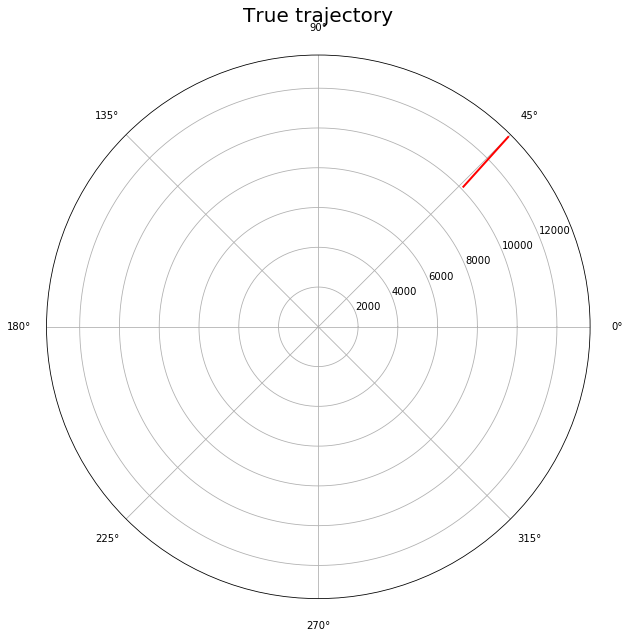

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('True trajectory', fontsize = 20)
ax.plot(b, D, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Generate measurements $D^m$ and $\beta^m$

In [26]:
sigma_D = 20
sigma_b = 0.02
D_n = np.random.normal(0, sigma_D, N)
b_n = np.random.normal(0, sigma_b, N)
D_m = D + D_n
b_m = b + b_n

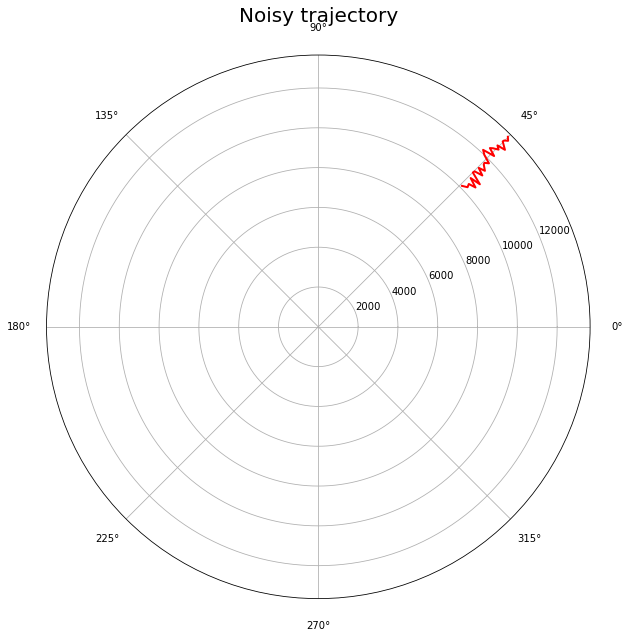

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Noisy trajectory', fontsize = 20)
ax.plot(b_m, D_m, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Transform polar coordinates 

In [82]:
x_m = D_m * np.sin(b_m)
y_m = D_m * np.cos(b_m)

# Create the measurement vector 

In [83]:
z = np.array([[x_m, y_m]]).transpose()

# Initial conditions for Kalman filter algorithm

In [84]:
X_0 = np.array([[40000], [-20], [40000], [-20]])
P_0 = np.eye(4) * 10 ** 10

# Create the transition matrix Φ and observation matrix H

In [85]:
T = np.zeros((4, 4))
T[0:2, 0:2] = np.array([[1, t], [0, 1]])
T[2:4, 2:4] = np.array([[1, t], [0, 1]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

# Create the measurement error covariance matrix  R

In [103]:
R = np.zeros((N, 2, 2))
R[:, 0, 0] = np.sin(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.cos(b_m) ** 2 * sigma_b ** 2
R[:, 0, 1] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
R[:, 1, 0] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
R[:, 1, 1] = np.cos(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.sin(b_m) ** 2 * sigma_b ** 2

# Develop Kalman filter algorithm

In [159]:
X, K, _, Xp = kalman(X_0, P_0, z, T, H, R, Q=0)

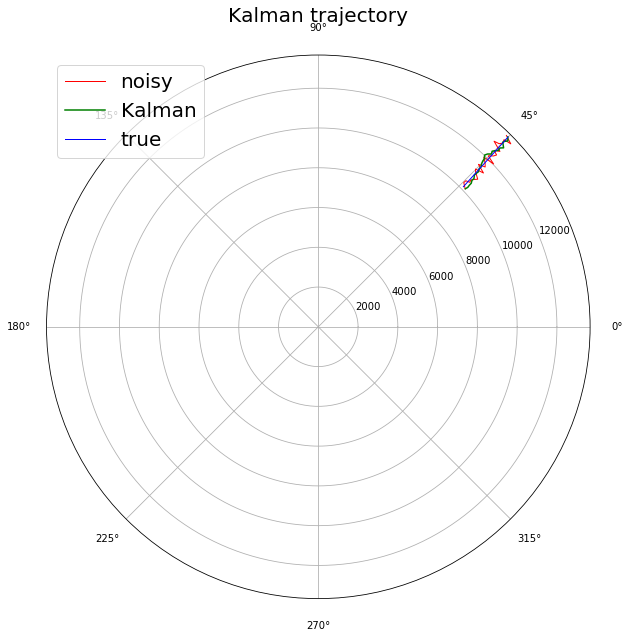

In [160]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Kalman trajectory', fontsize = 20)
ax.plot(b_m, D_m, 'r', linewidth=1, label="noisy")
ax.plot(*convert_to_polar(X), 'g', linewidth=1.5, label="Kalman")
ax.plot(b, D, 'b', linewidth=1, label="true")
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.legend(loc = 'upper left', fontsize=20)

# Run Kalman filter algorithm over M = 500

In [174]:
M = 500
N = 26
t = 2
vx_0 = -50
vy_0 = -45
x_0 = 13500 / 2 ** 0.5
y_0 = 13500 / 2 ** 0.5
sigma_D = 20
sigma_b = 0.02

error_b_f = np.zeros((N, M))
error_D_f = np.zeros((N, M))
error_b_p = np.zeros((N, M))
error_D_p = np.zeros((N, M))

for i in range(M):
    vx = np.ones((N)) * vx_0
    vy = np.ones((N)) * vy_0
    x = np.ones((N)) * x_0 + (vx * t).dot(np.triu(np.ones((N, N)), 1))
    y = np.ones((N)) * x_0 + (vy * t).dot(np.triu(np.ones((N, N)), 1))

    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    D_n = np.random.normal(0, sigma_D, N)
    b_n = np.random.normal(0, sigma_b, N)
    D_m = D + D_n
    b_m = b + b_n
    
    x_m = D_m * np.sin(b_m)
    y_m = D_m * np.cos(b_m)
    
    z = np.array([[x_m, y_m]]).transpose()
    
    R = np.zeros((N, 2, 2))
    R[:, 0, 0] = np.sin(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.cos(b_m) ** 2 * sigma_b ** 2
    R[:, 0, 1] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 0] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 1] = np.cos(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.sin(b_m) ** 2 * sigma_b ** 2
    
    X, _, _, Xp = kalman(X_0, P_0, z, T, H, R, Q=0)
    
    b_f, D_f = convert_to_polar(X)
    b_p, D_p = convert_to_polar(Xp)
    
    error_b_f[:,i] = (b - b_f) ** 2
    error_D_f[:,i] = (D - D_f) ** 2
    error_b_p[:,i] = (b - b_p) ** 2
    error_D_p[:,i] = (D - D_p) ** 2

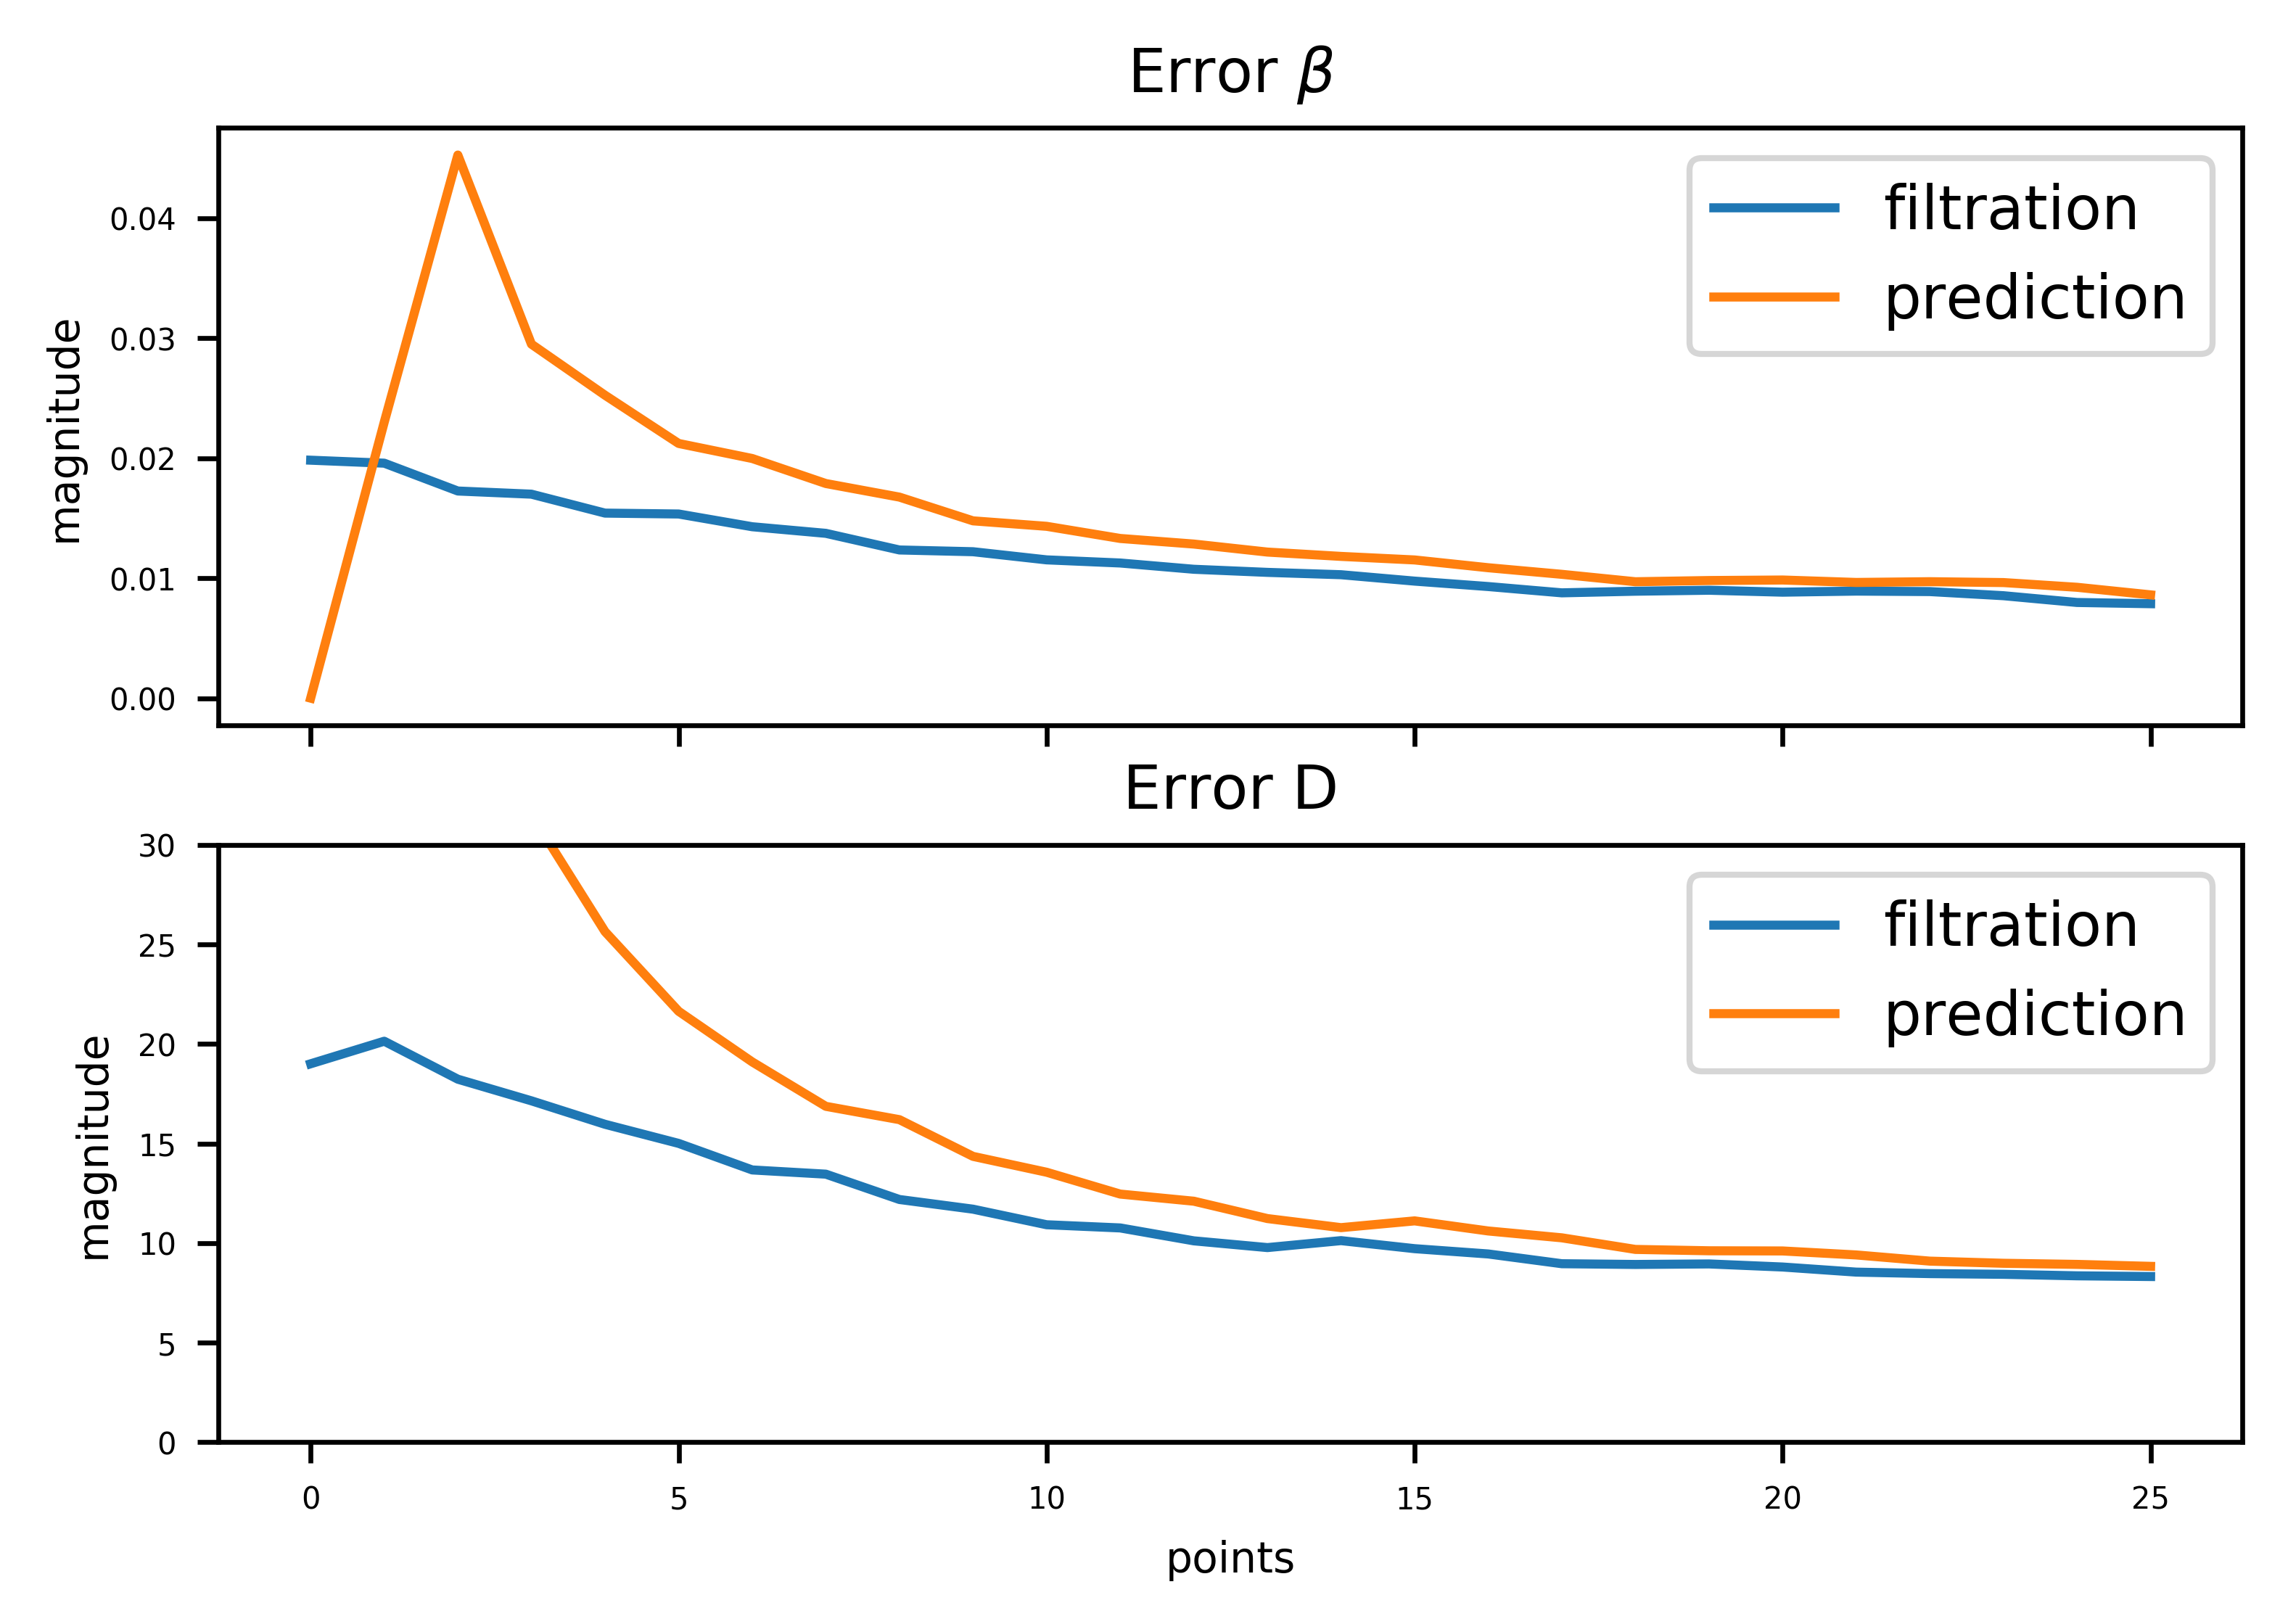

In [175]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex = True)
ax[0].set_title(r'Error $\beta$', fontsize = 10)
ax[0].plot( (np.sum(error_b_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(error_b_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('magnitude', fontsize = 7)

ax[1].set_title('Error D', fontsize = 10)
ax[1].plot( (np.sum(error_D_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(error_D_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].set_ylim(0, 30);

### The error of D decreases, but the error of $\beta$ remains same

# Analyze dependence of coordinate on azimuth 

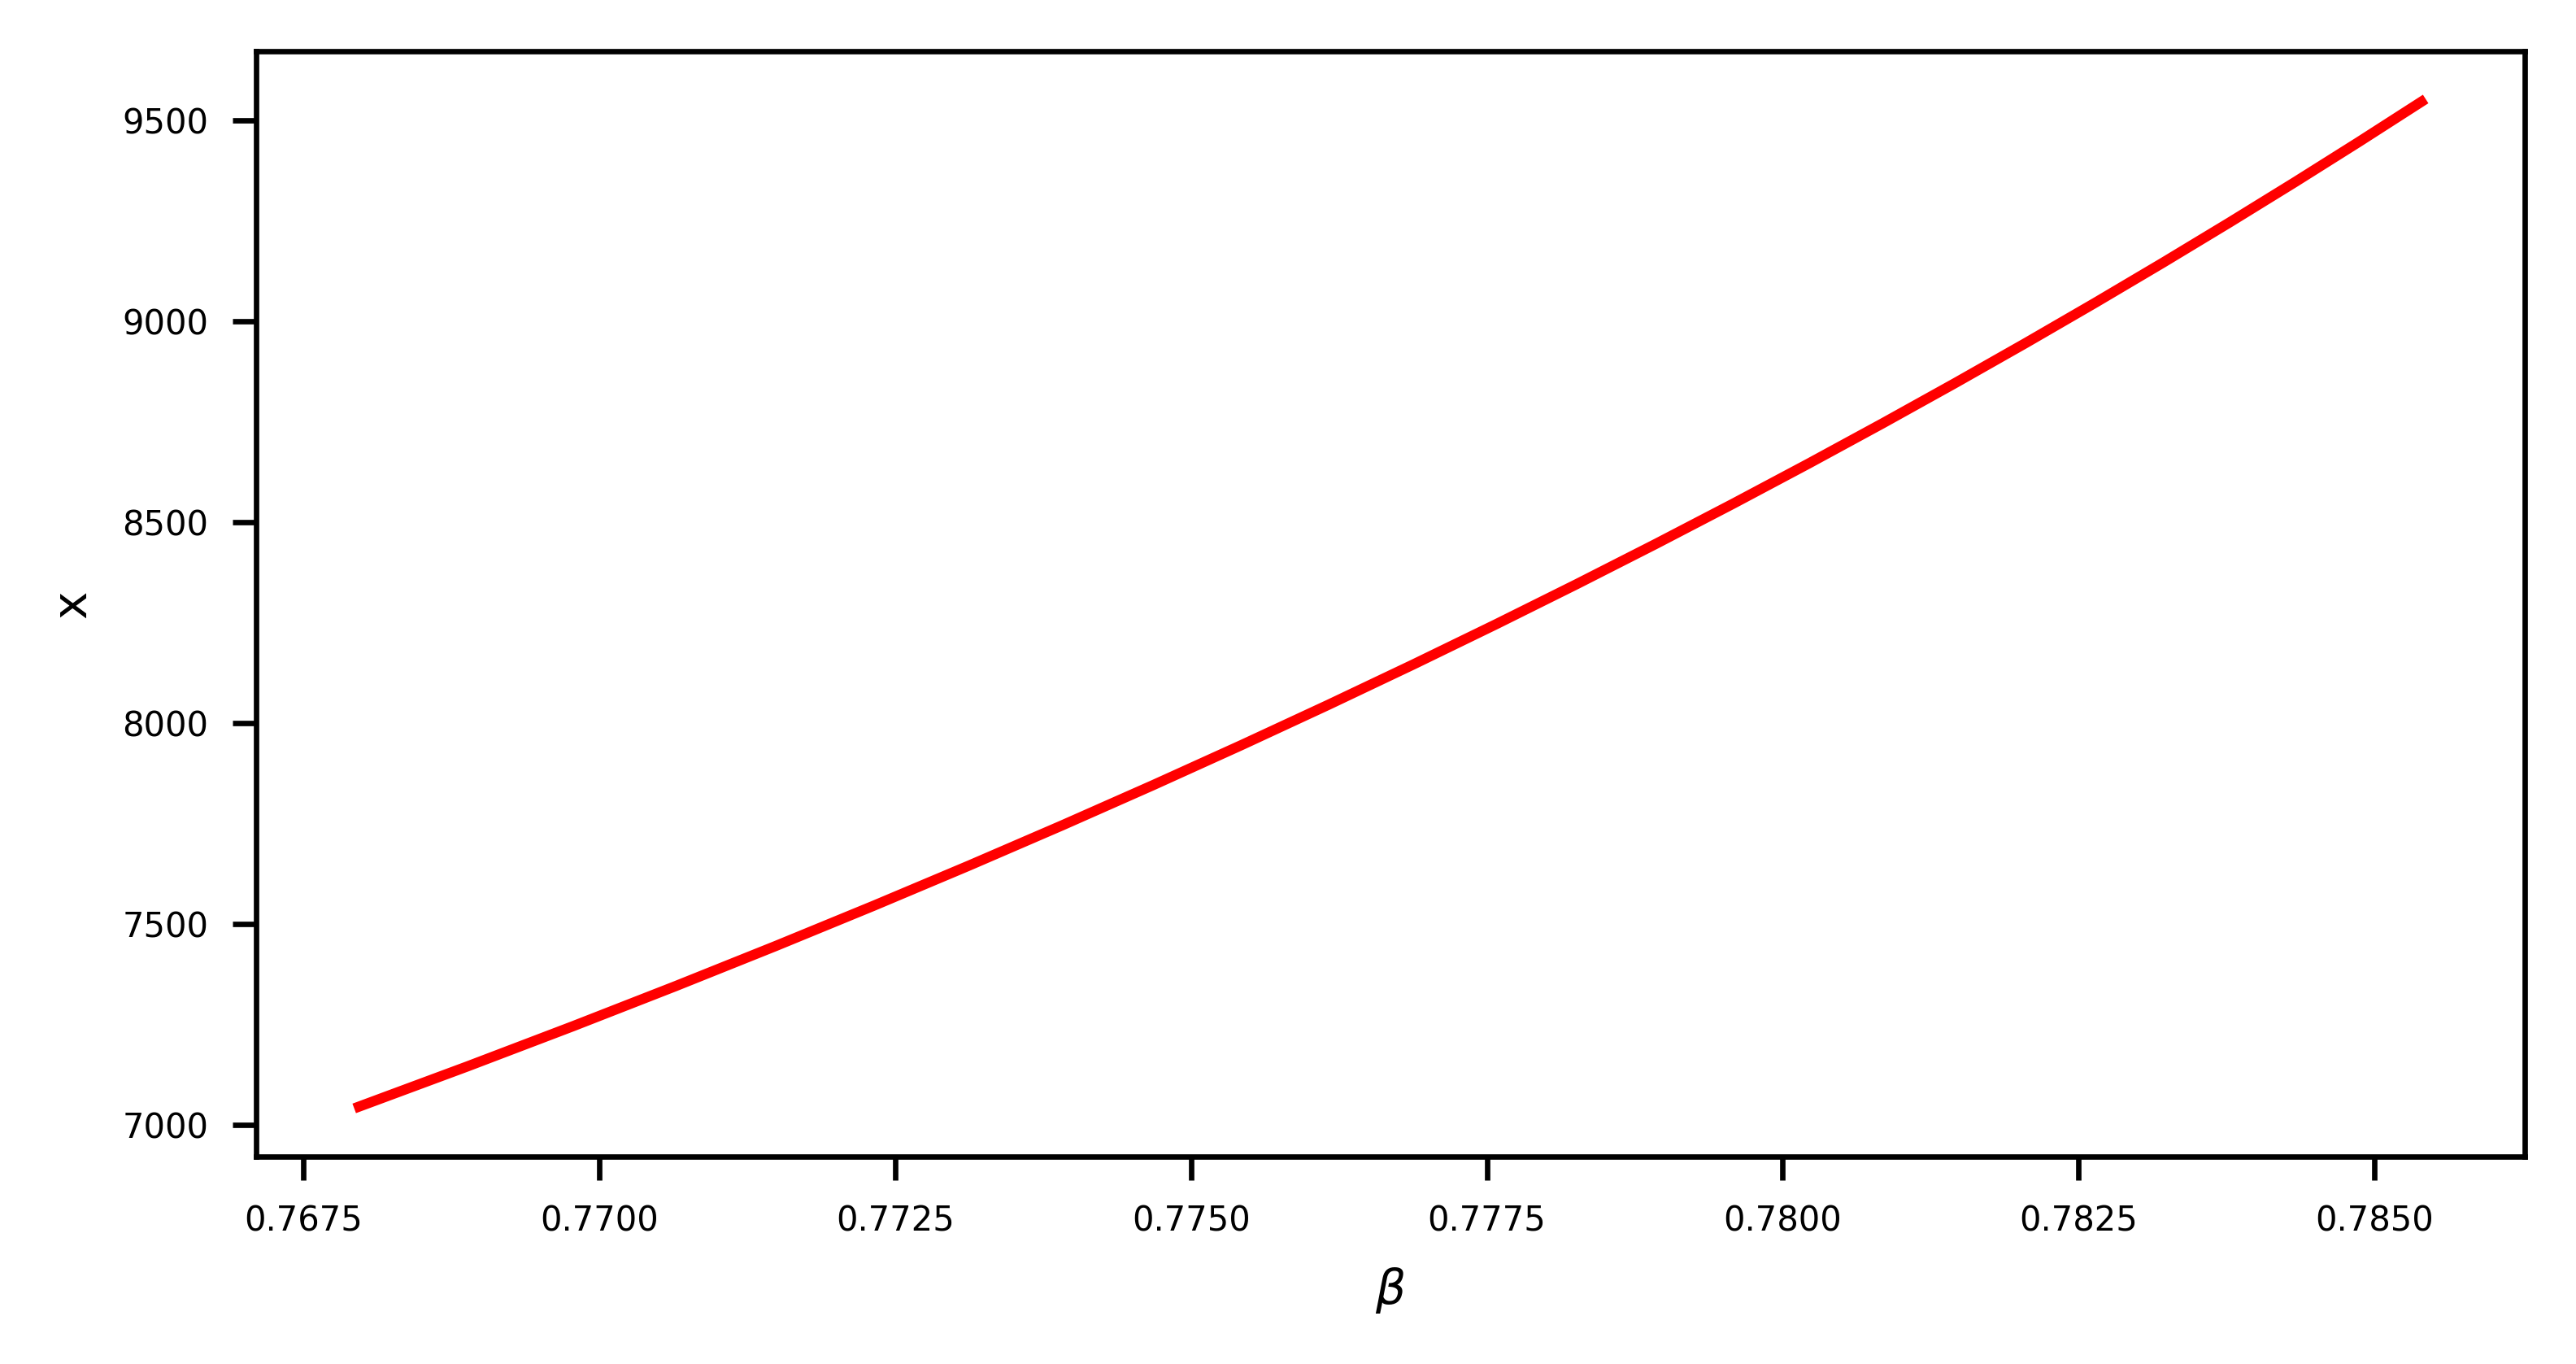

In [154]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi = 600)
ax.plot(b, x, 'r')
ax.set_ylabel('x', fontsize = 7)
ax.set_xlabel(r'$\beta$', fontsize = 7);

###  The dependence in this region is exactly linear 

# Calculate condition number of covariance matrix

In [156]:
cond_number = D_m ** 2 * sigma_b ** 2 / sigma_D ** 2
print(cond_number)

[ 182.09785286  178.36107179  175.78829697  171.45512117  167.47121624
  165.25321911  161.27610204  156.87779471  155.06462771  151.54397988
  146.92958174  144.76474709  142.09394633  138.2738676   134.97935683
  131.6038484   128.81102606  125.48400279  123.35960915  119.36559495
  116.88271523  113.22491665  110.86830678  109.01074934  106.17093135
  102.72925903]


### Condition numbers are small compared with 1000, but large compared with 1

# Analyze filter gain 

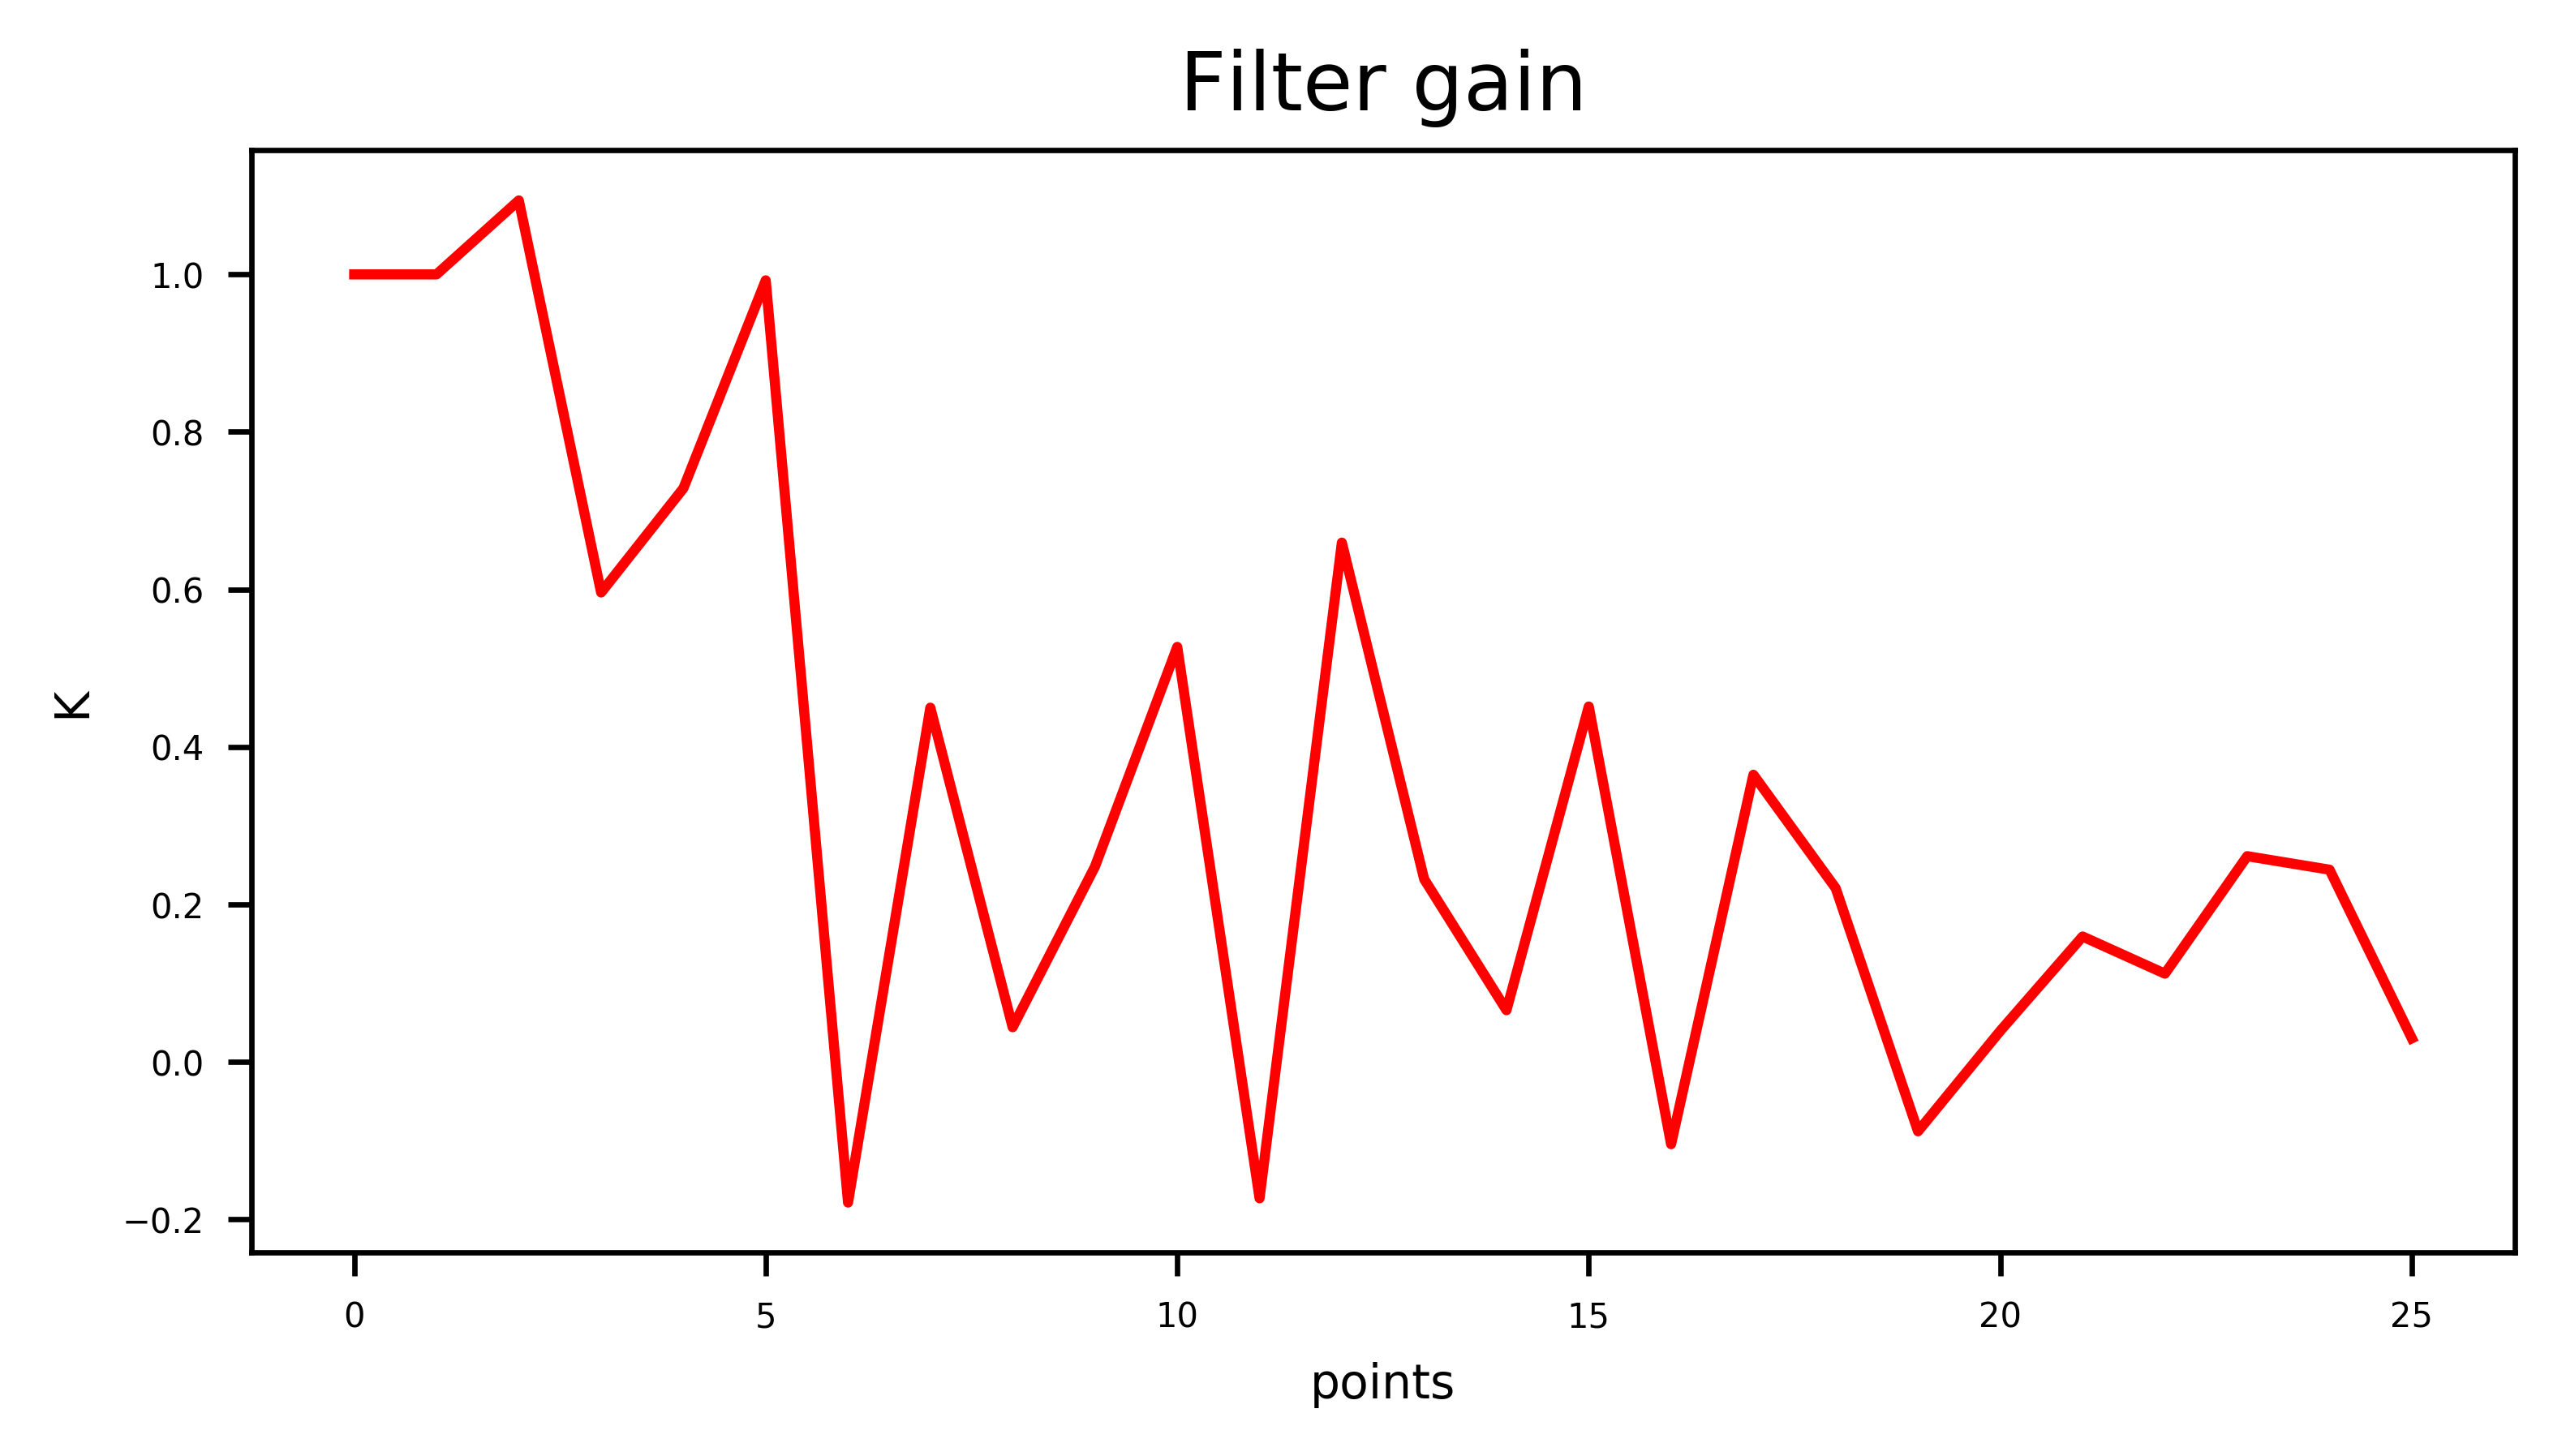

In [163]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi = 600)
ax.set_title("Filter gain")
ax.plot(K[:,0,0], 'r')
ax.set_ylabel('K', fontsize = 7)
ax.set_xlabel(r'points', fontsize = 7);

# Run filter again M = 500 when an object starts it motion at a quite close distance from an observer

# Calculate true errors of estimation

In [176]:
M = 500
N = 26
t = 2
vx_0 = -50
vy_0 = -45
x_0 = 3500 / 2 ** 0.5
y_0 = 3500 / 2 ** 0.5
sigma_D = 20
sigma_b = 0.02

error_b_f = np.zeros((N, M))
error_D_f = np.zeros((N, M))
error_b_p = np.zeros((N, M))
error_D_p = np.zeros((N, M))

for i in range(M):
    vx = np.ones((N)) * vx_0
    vy = np.ones((N)) * vy_0
    x = np.ones((N)) * x_0 + (vx * t).dot(np.triu(np.ones((N, N)), 1))
    y = np.ones((N)) * x_0 + (vy * t).dot(np.triu(np.ones((N, N)), 1))

    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    D_n = np.random.normal(0, sigma_D, N)
    b_n = np.random.normal(0, sigma_b, N)
    D_m = D + D_n
    b_m = b + b_n
    
    x_m = D_m * np.sin(b_m)
    y_m = D_m * np.cos(b_m)
    
    z = np.array([[x_m, y_m]]).transpose()
    
    R = np.zeros((N, 2, 2))
    R[:, 0, 0] = np.sin(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.cos(b_m) ** 2 * sigma_b ** 2
    R[:, 0, 1] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 0] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 1] = np.cos(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.sin(b_m) ** 2 * sigma_b ** 2
    
    X, _, _, Xp = kalman(X_0, P_0, z, T, H, R, Q=0)
    
    b_f, D_f = convert_to_polar(X)
    b_p, D_p = convert_to_polar(Xp)
    
    error_b_f[:,i] = (b - b_f) ** 2
    error_D_f[:,i] = (D - D_f) ** 2
    error_b_p[:,i] = (b - b_p) ** 2
    error_D_p[:,i] = (D - D_p) ** 2

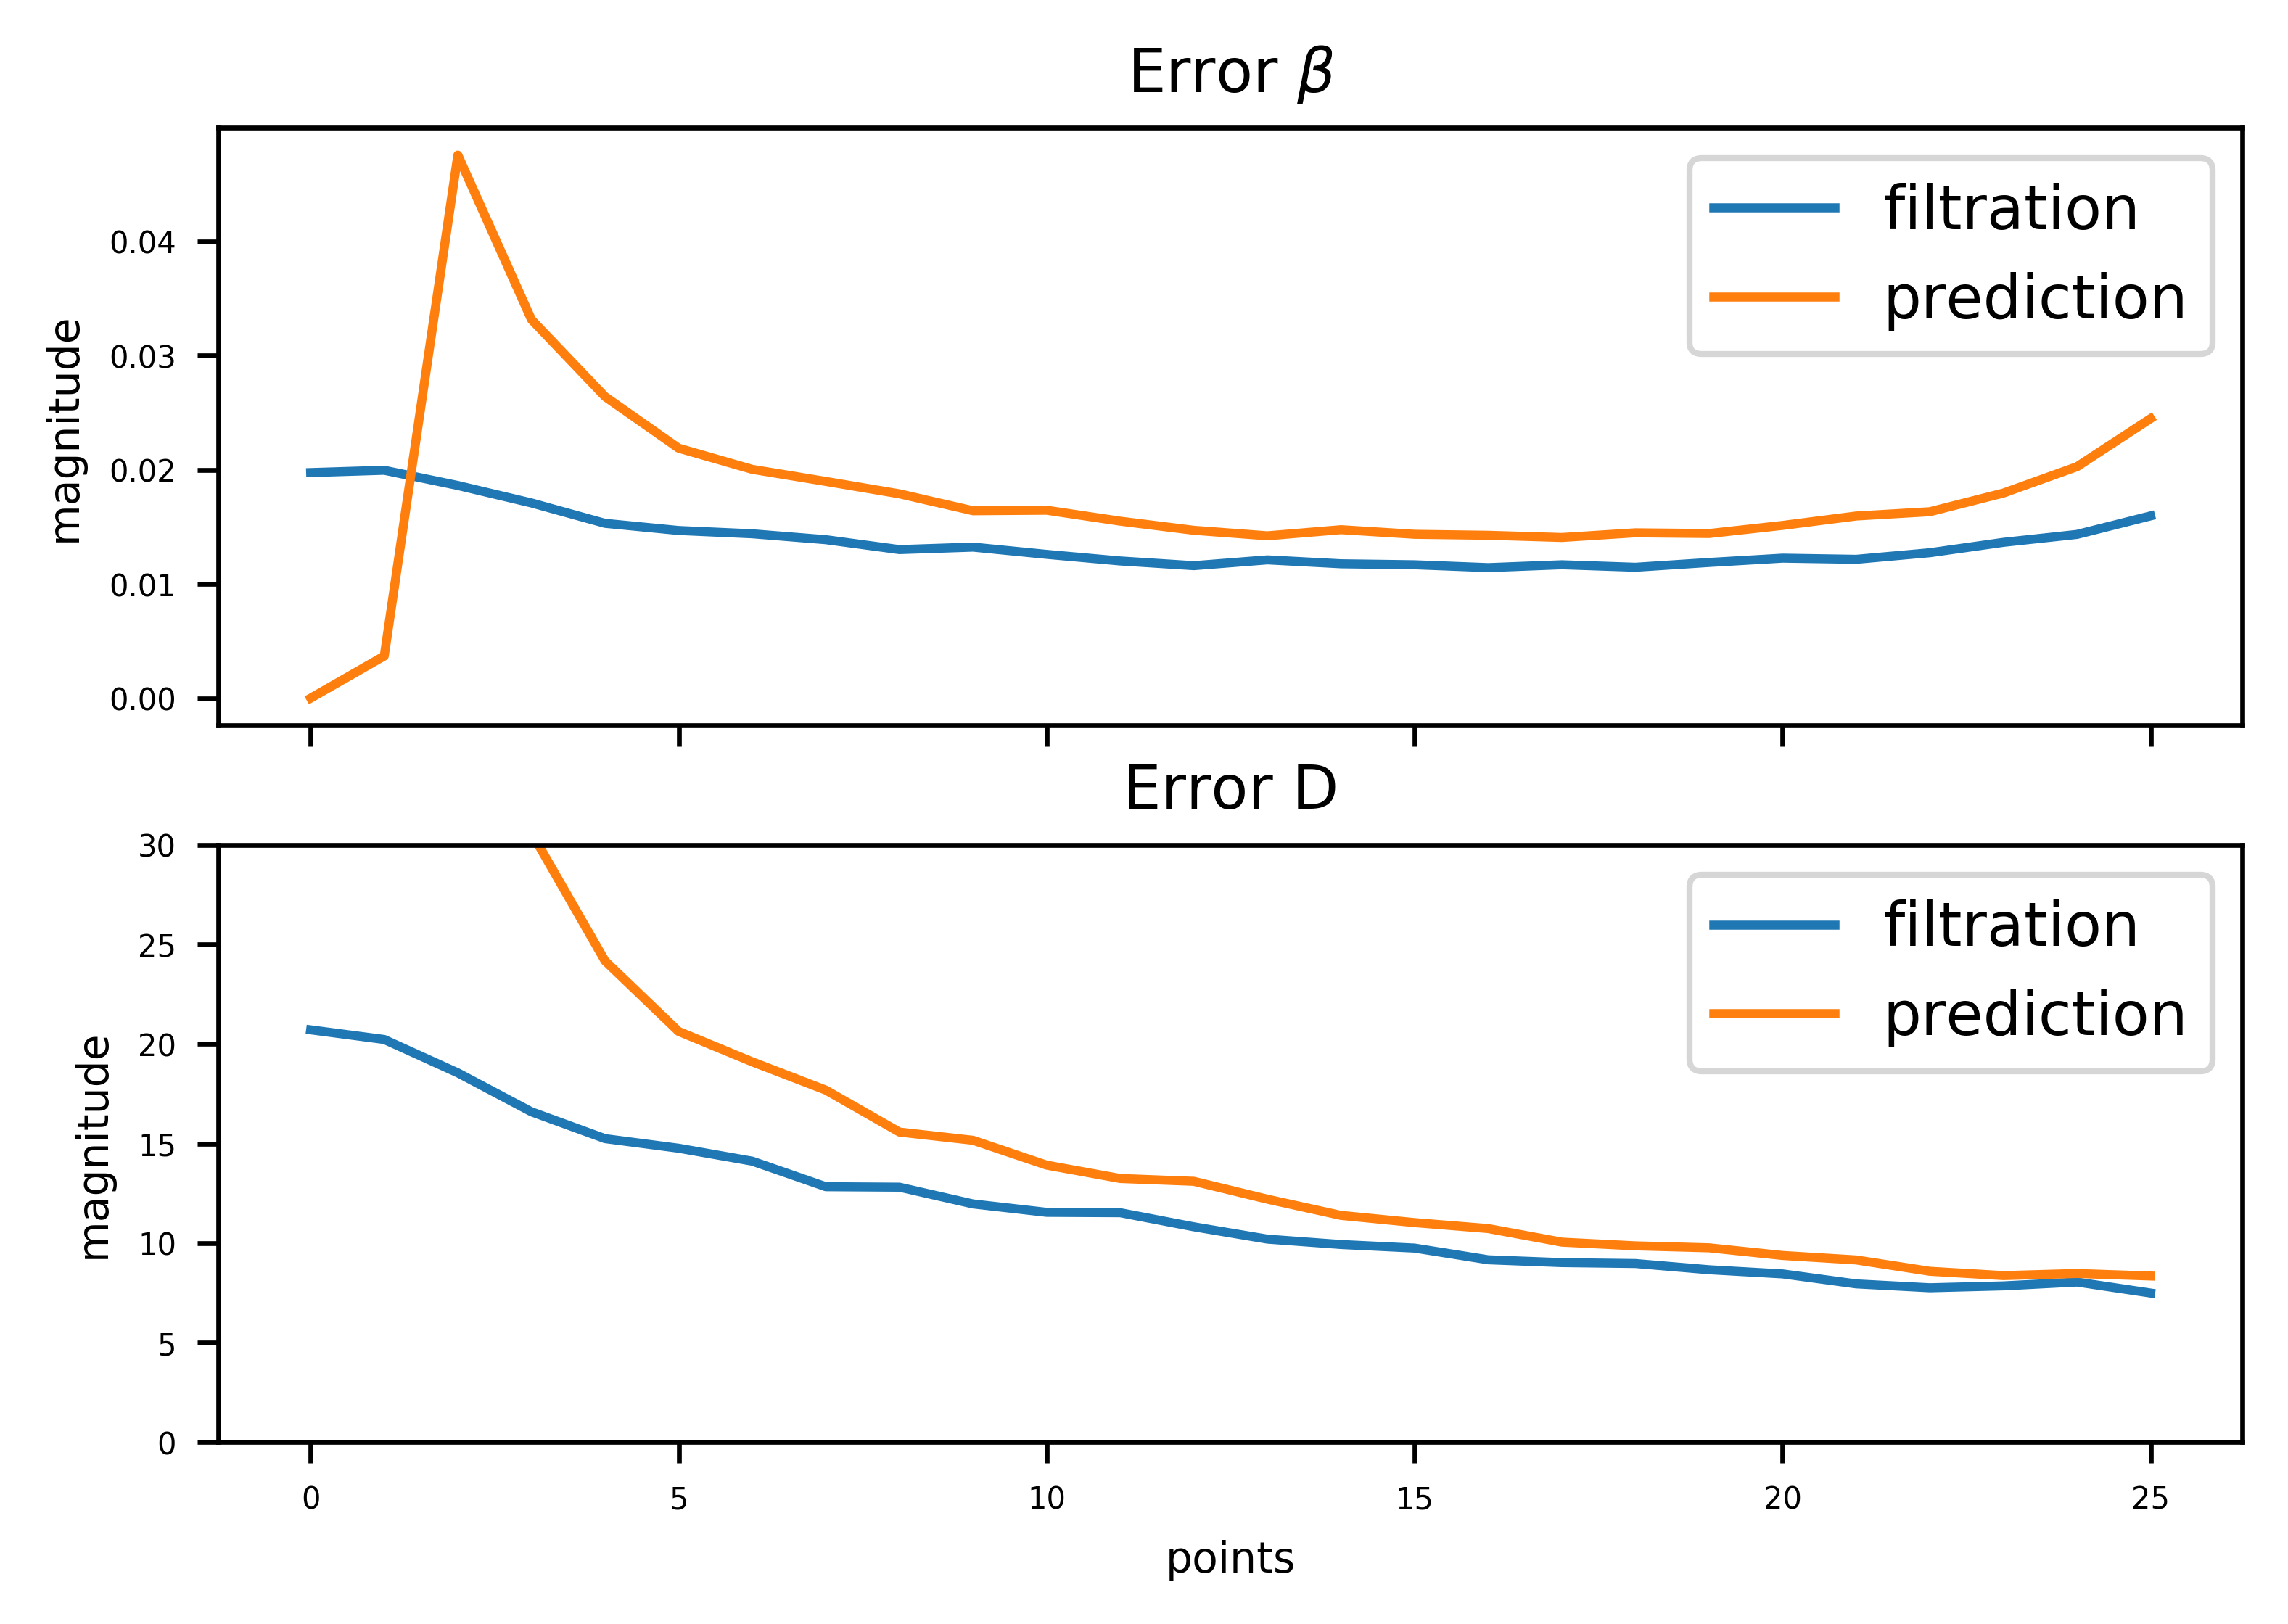

In [177]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex = True)
ax[0].set_title(r'Error $\beta$', fontsize = 10)
ax[0].plot( (np.sum(error_b_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(error_b_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('magnitude', fontsize = 7)

ax[1].set_title('Error D', fontsize = 10)
ax[1].plot( (np.sum(error_D_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(error_D_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].set_ylim(0, 30);

### The error of D decreases, but the error after some point start to increase

# Analyze dependence of coordinate x on azimuth $\beta$

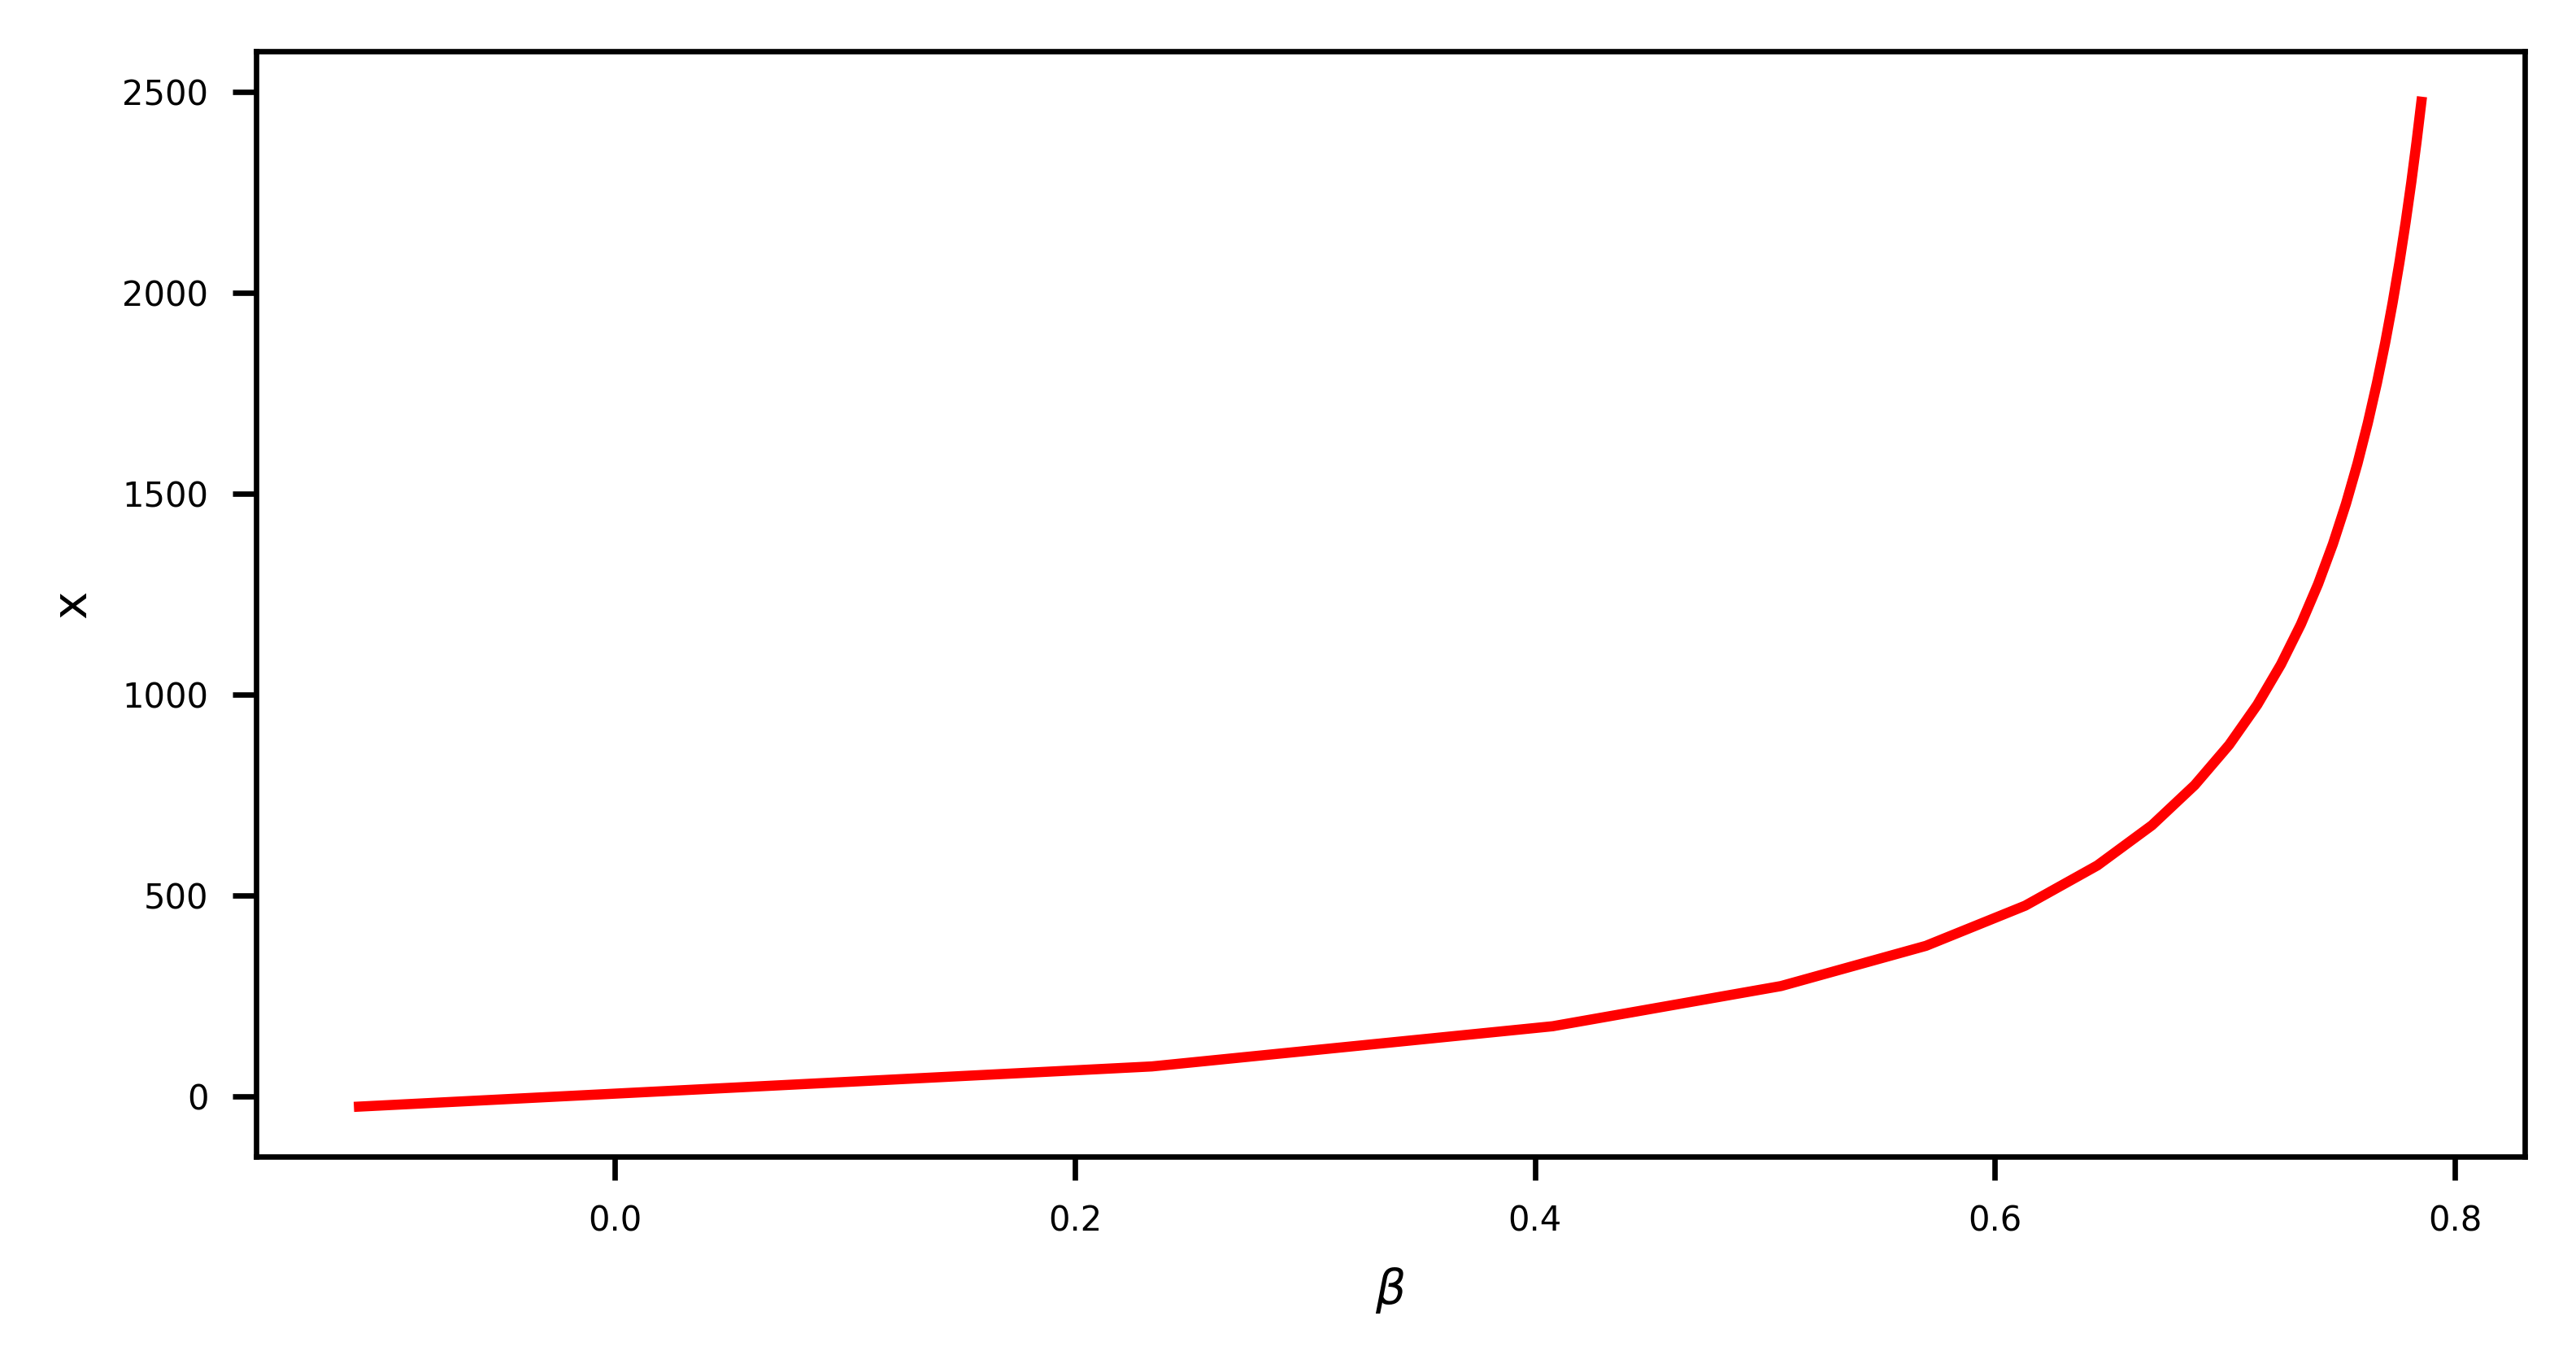

In [178]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi = 600)
ax.plot(b, x, 'r')
ax.set_ylabel('x', fontsize = 7)
ax.set_xlabel(r'$\beta$', fontsize = 7);

### Dependence x from $\beta$ is greatly non-linear  

# Calculate condition number of covariance matrix R

In [179]:
cond_number = D_m ** 2 * sigma_b ** 2 / sigma_D ** 2
print(cond_number)

[ 12.09054718  11.30747679  10.27856001   9.71461231   8.81775643
   7.97727593   7.06766931   6.5395941    5.9118608    5.31786983
   4.6373925    4.20657709   3.53585233   3.02156067   2.57135579
   2.33324084   1.81159972   1.42288073   1.21696928   0.94240178
   0.66452668   0.50443361   0.33988275   0.18528757   0.0972112
   0.0522159 ]


### Condition numbers are less than 1 starting from some point 

# Make conclusions how linearization errors affect tracking accuracy and how important for tracking accuracy is starting position of a moving object (close or far from an observer)

### When condition number is less than 1 and dependence x from $\beta$ is non-linear error is big

# Run filter again over M = 500 runs

# Repeat items 14, 15, 16, 17

In [182]:
M = 500
N = 26
t = 2
vx_0 = -50
vy_0 = -45
x_0 = 3500 / 2 ** 0.5
y_0 = 3500 / 2 ** 0.5
sigma_D = 50
sigma_b = 0.0015

error_b_f = np.zeros((N, M))
error_D_f = np.zeros((N, M))
error_b_p = np.zeros((N, M))
error_D_p = np.zeros((N, M))

for i in range(M):
    vx = np.ones((N)) * vx_0
    vy = np.ones((N)) * vy_0
    x = np.ones((N)) * x_0 + (vx * t).dot(np.triu(np.ones((N, N)), 1))
    y = np.ones((N)) * x_0 + (vy * t).dot(np.triu(np.ones((N, N)), 1))

    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    D_n = np.random.normal(0, sigma_D, N)
    b_n = np.random.normal(0, sigma_b, N)
    D_m = D + D_n
    b_m = b + b_n
    
    x_m = D_m * np.sin(b_m)
    y_m = D_m * np.cos(b_m)
    
    z = np.array([[x_m, y_m]]).transpose()
    
    R = np.zeros((N, 2, 2))
    R[:, 0, 0] = np.sin(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.cos(b_m) ** 2 * sigma_b ** 2
    R[:, 0, 1] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 0] = np.sin(b_m) * np.cos(b_m) * (sigma_D ** 2 - D_m ** 2 * sigma_b ** 2)
    R[:, 1, 1] = np.cos(b_m) ** 2 * sigma_D ** 2 + D_m ** 2 * np.sin(b_m) ** 2 * sigma_b ** 2
    
    X, _, _, Xp = kalman(X_0, P_0, z, T, H, R, Q=0)
    
    b_f, D_f = convert_to_polar(X)
    b_p, D_p = convert_to_polar(Xp)
    
    error_b_f[:,i] = (b - b_f) ** 2
    error_D_f[:,i] = (D - D_f) ** 2
    error_b_p[:,i] = (b - b_p) ** 2
    error_D_p[:,i] = (D - D_p) ** 2

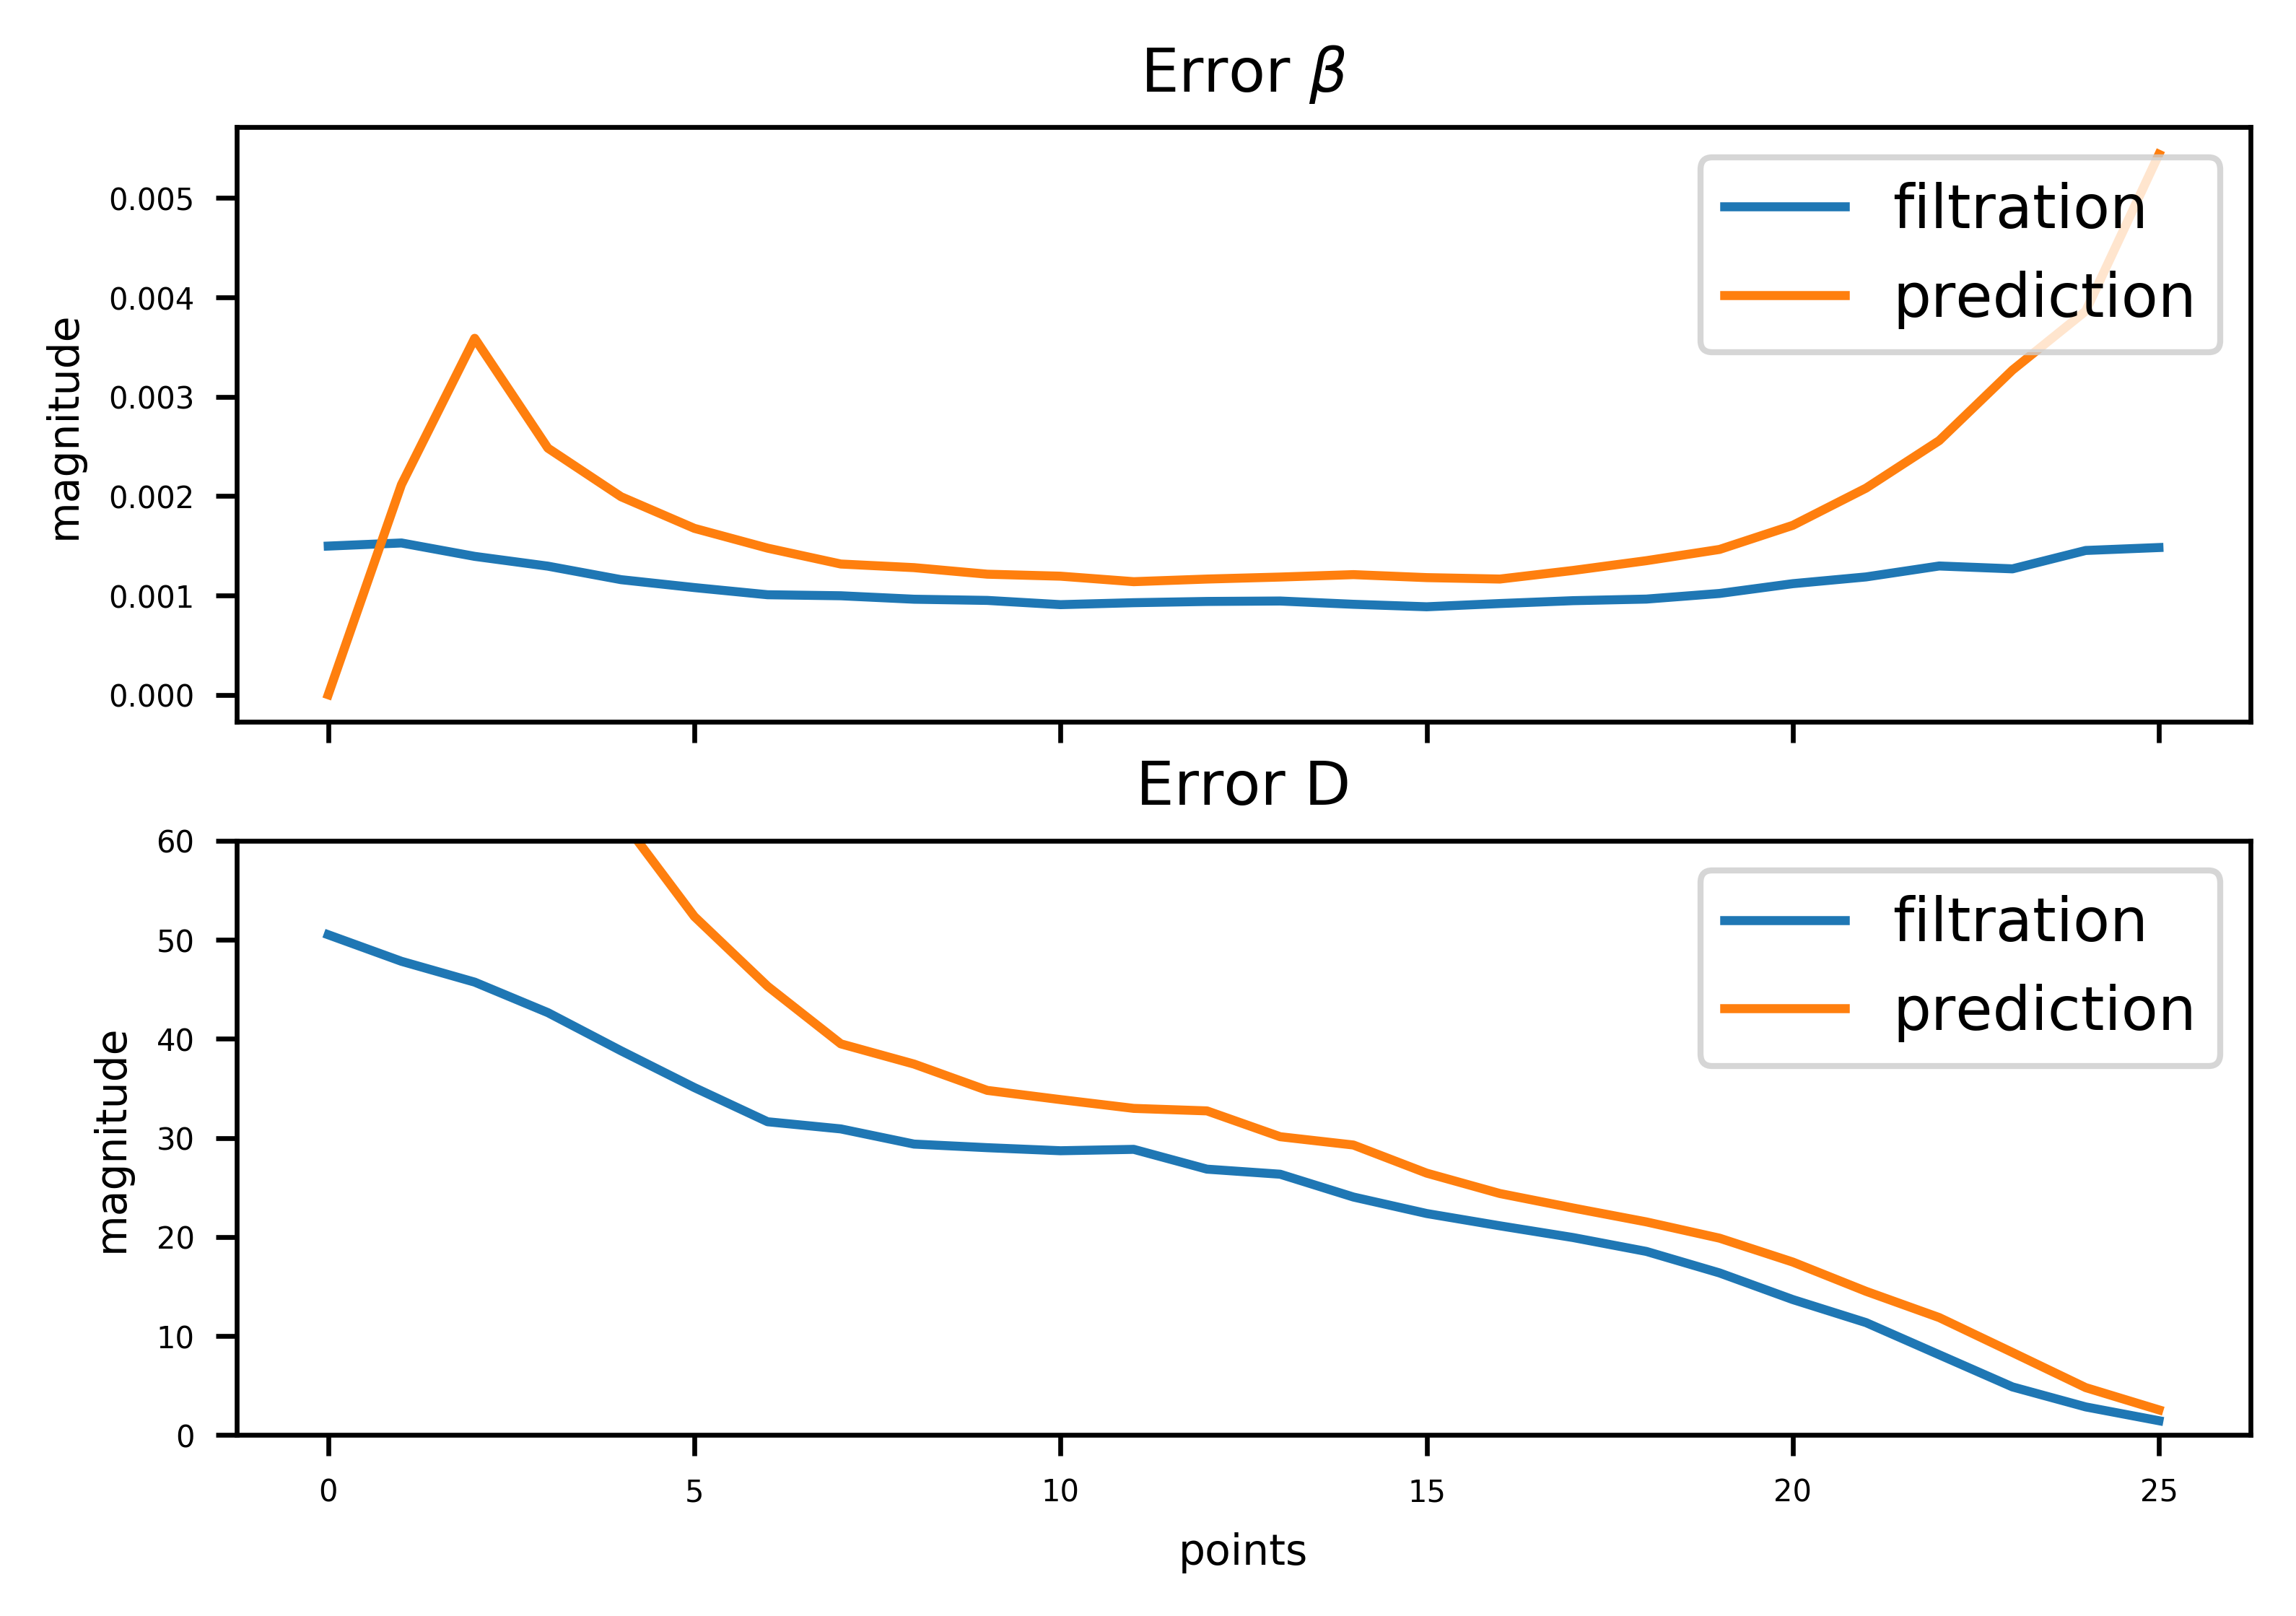

In [186]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex = True)
ax[0].set_title(r'Error $\beta$', fontsize = 10)
ax[0].plot( (np.sum(error_b_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(error_b_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('magnitude', fontsize = 7)

ax[1].set_title('Error D', fontsize = 10)
ax[1].plot( (np.sum(error_D_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(error_D_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].set_ylim(0, 60);

In [187]:
cond_number = D_m ** 2 * sigma_b ** 2 / sigma_D ** 2
print(cond_number)

[  1.11202345e-02   1.00048914e-02   9.44945211e-03   8.40273088e-03
   7.78206575e-03   7.10849398e-03   6.71301163e-03   5.87895517e-03
   5.30022802e-03   4.58680140e-03   4.13663248e-03   3.77594061e-03
   3.05811398e-03   2.94256427e-03   2.43151238e-03   2.12362347e-03
   1.70786962e-03   1.34739879e-03   1.23562653e-03   8.75602419e-04
   7.45010662e-04   4.33451530e-04   4.00091751e-04   2.15290034e-04
   6.79161594e-05   5.80196668e-05]


### Condition numbers are greatly less than 1 and they decrease over time

# Conclusion

### Thus when coordinates are closer to zero, conditions become more diffucult and errors become greater 